In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_log_error

#matplotlib setting defaults
# sns.set(font="Arial",
#         rc={
#  "axes.axisbelow": False,
#  "axes.edgecolor": "lightgrey",
#  "axes.facecolor": "None",
#  "axes.grid": False,
#  "axes.labelcolor": "dimgrey",
#  "axes.spines.right": False,
#  "axes.spines.top": False,
#  "figure.facecolor": "white",
#  "lines.solid_capstyle": "round",
#  "patch.edgecolor": "w",
#  "patch.force_edgecolor": True,
#  "text.color": "dimgrey",
#  "xtick.bottom": False,
#  "xtick.color": "dimgrey",
#  "xtick.direction": "out",
#  "xtick.top": False,
#  "ytick.color": "dimgrey",
#  "ytick.direction": "out",
#  "ytick.left": False,
#  "ytick.right": False})

import warnings
warnings.filterwarnings("ignore")

/home/bildad/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))


def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    '''MAP is risky if there are zero days, which means that there is division by 0, leading to infinite values'''
    actual, pred = np.array(actual), np.array(pred)
    actual = np.where(actual ==0, 1e-10, actual)
    # return np.mean(np.abs((actual - pred) / actual)) * 100
    return mean_absolute_percentage_error(actual, pred)

def RMSLE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return root_mean_squared_log_error(actual, pred)

## Reading Data
- Sales dataset from kaggle Favorita Stores in Ecuador.
- ref( https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [3]:
df = pd.read_csv('./csvs/train.csv')
df['date'] = pd.to_datetime(df['date'], format= 'ISO8601')

In [4]:
## See the range of dates in the data
min(df['date']), max(df['date']) # 4 years, 7 months, 14 days

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [5]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [6]:
df.describe()

,id,date,store_nbr,sales,onpromotion
count,3000888.00,3000888,3000888.00,3000888.00,3000888.00
mean,1500443.50,2015-04-24 08:27:04.703088384,27.50,357.78,2.60
min,0.00,2013-01-01 00:00:00,1.00,0.00,0.00
25%,750221.75,2014-02-26 18:00:00,14.00,0.00,0.00
50%,1500443.50,2015-04-24 12:00:00,27.50,11.00,0.00
75%,2250665.25,2016-06-19 06:00:00,41.00,195.85,0.00
max,3000887.00,2017-08-15 00:00:00,54.00,124717.00,741.00
std,866281.89,NaN,15.59,1102.00,12.22


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL. select date, family, sum(sales) from df group by date, family

In [7]:
agg_df = df.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index().sort_values(['family', 'date'])

In [8]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


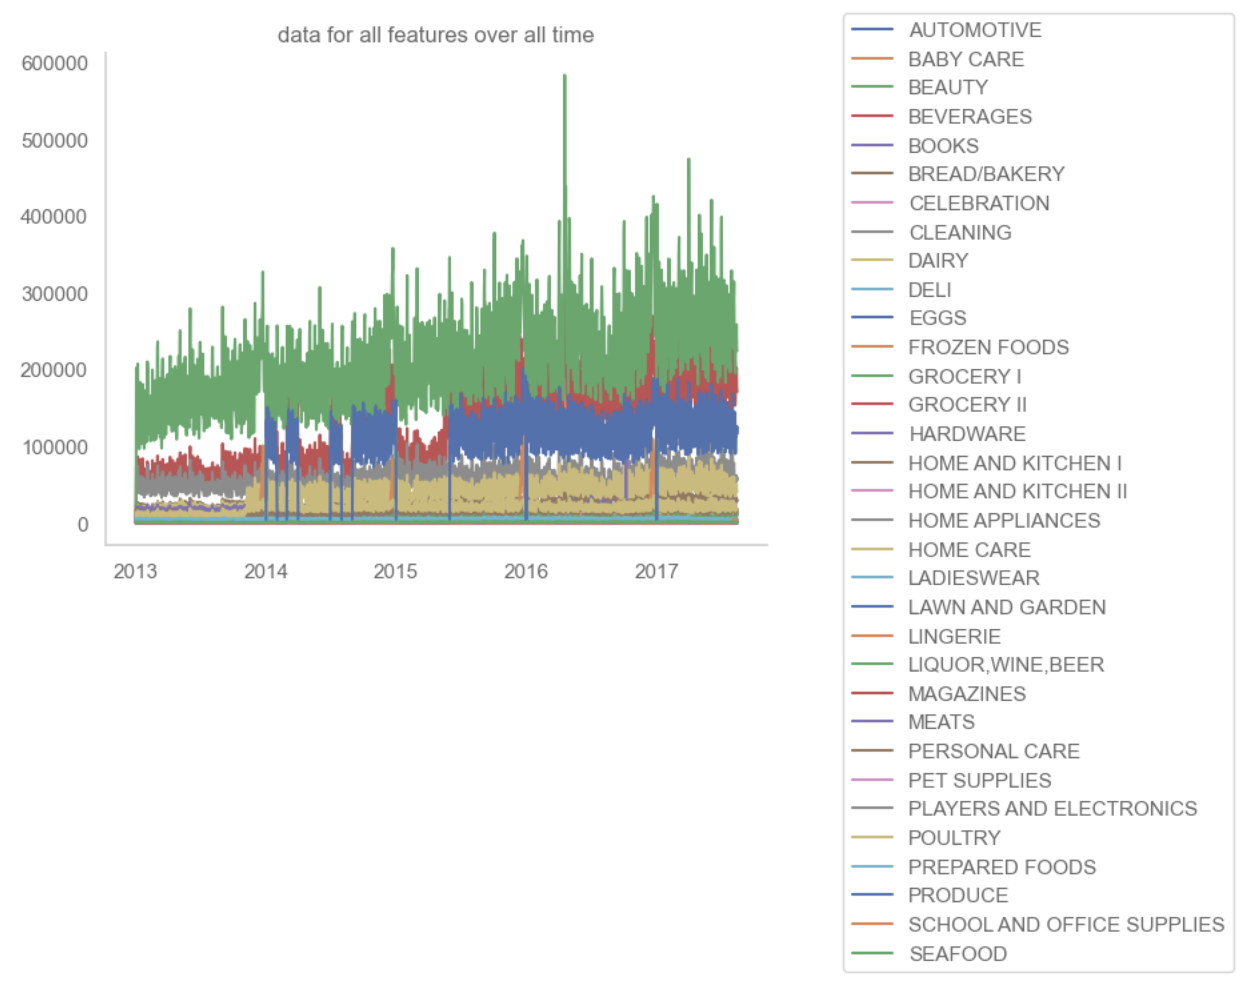

- With such data, we build a time-series model for each category seperately.

In [9]:
total_sales_df = agg_df.pivot(index='date', columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,...,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,...,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,...,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,...,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,...,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


## Plot the sales of each column(family)

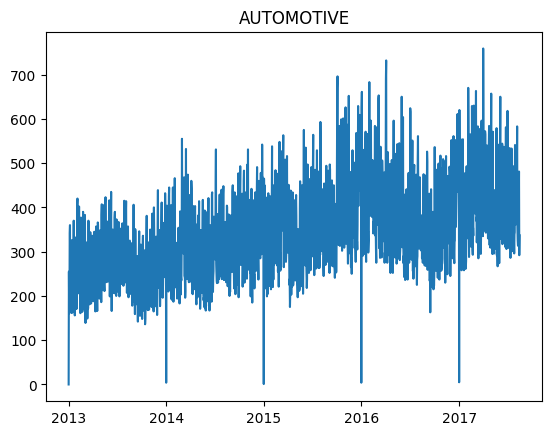

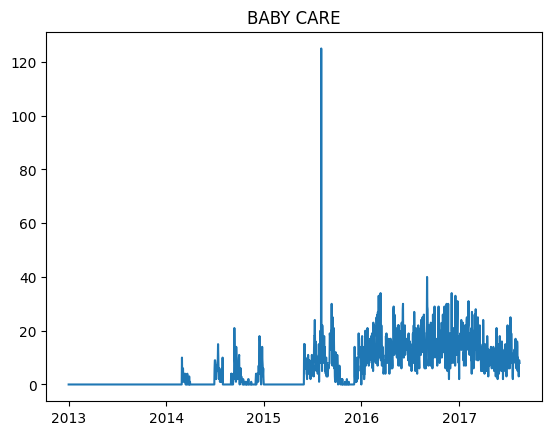

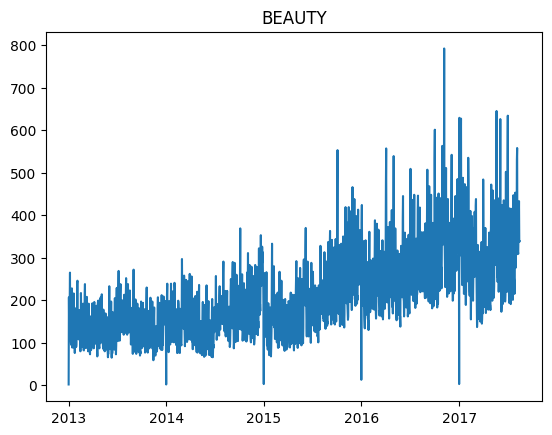

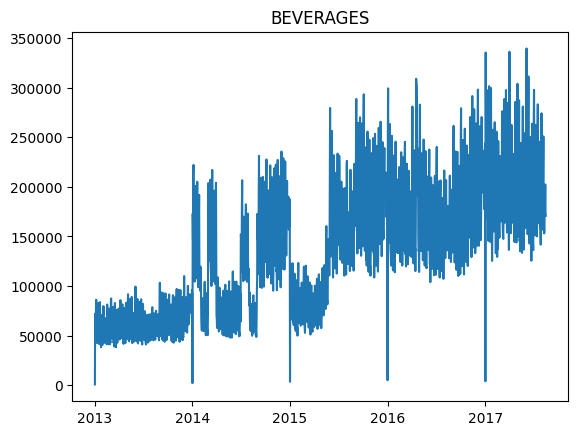

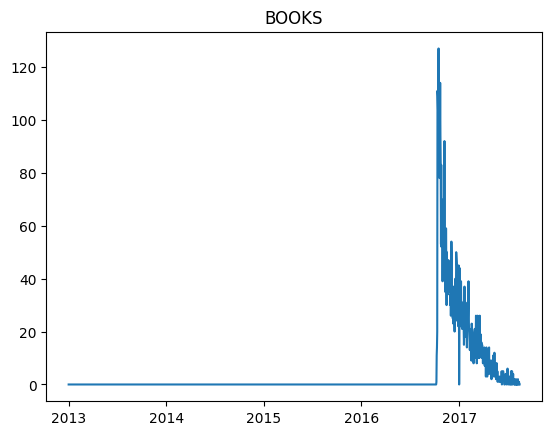

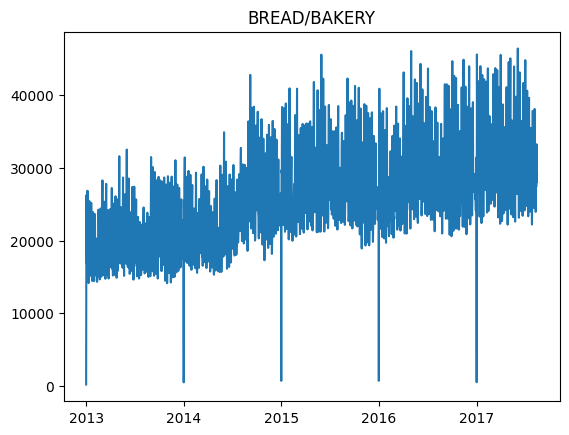

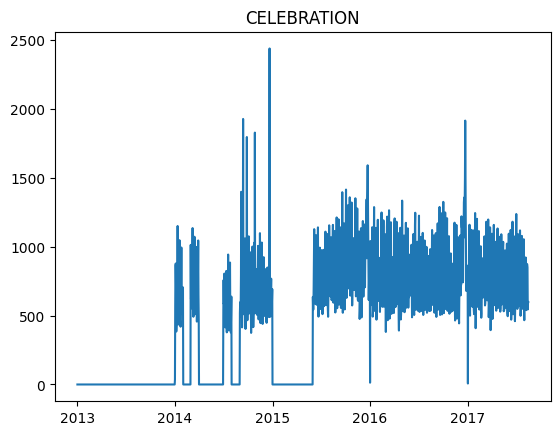

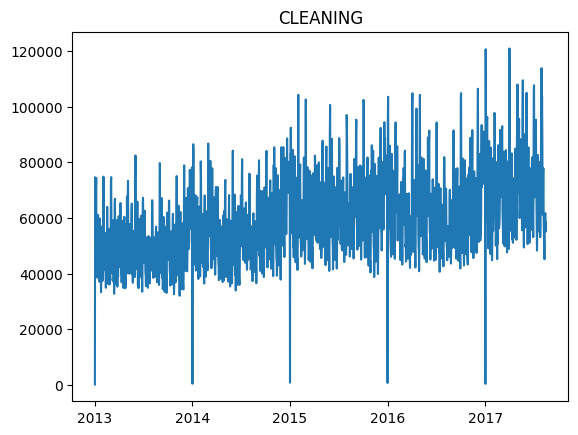

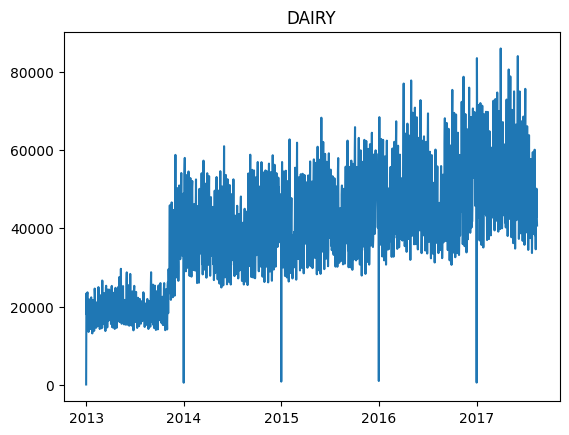

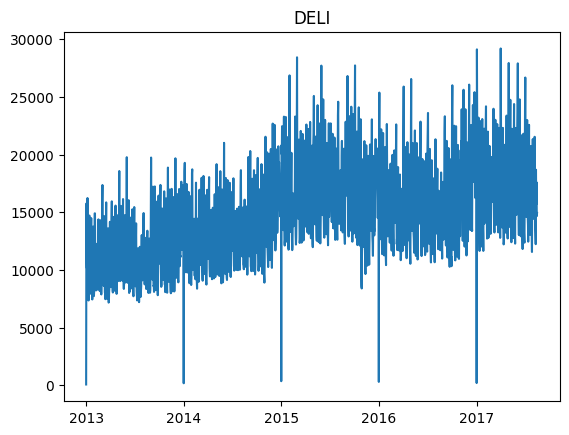

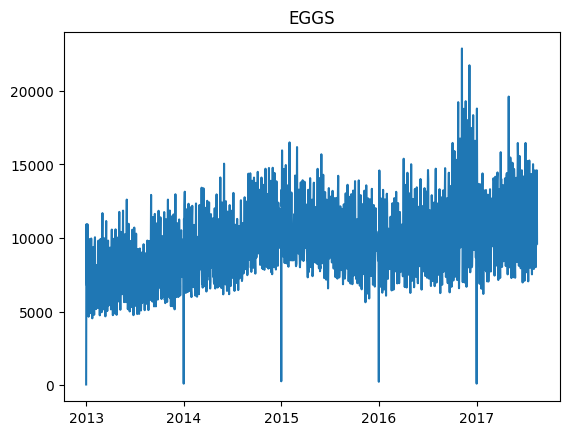

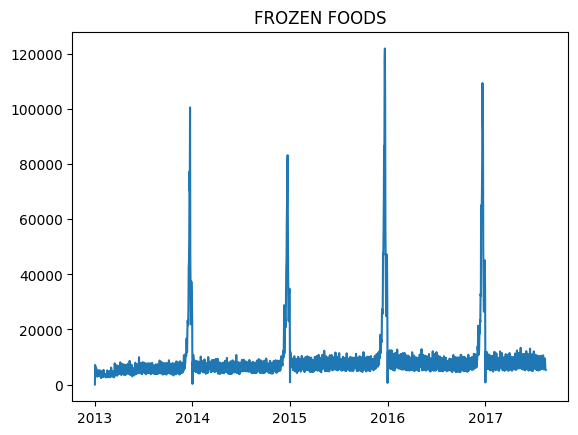

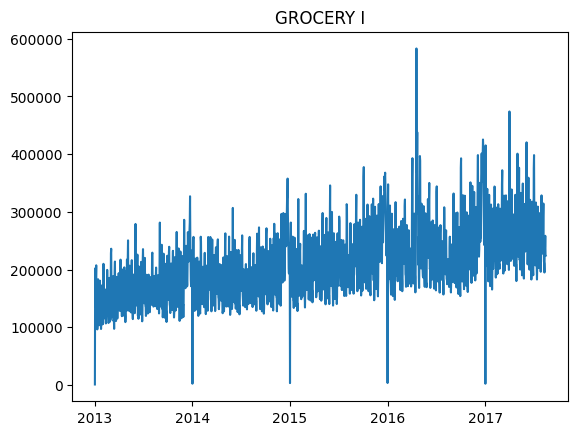

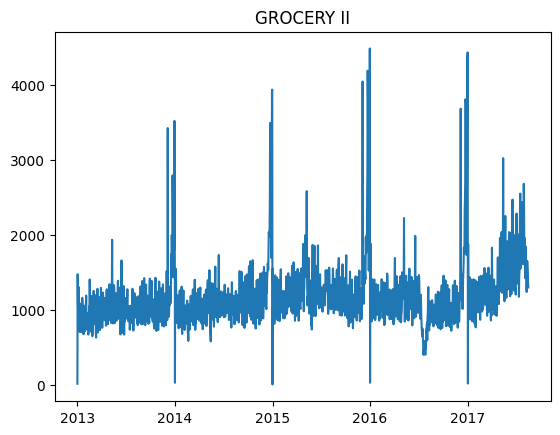

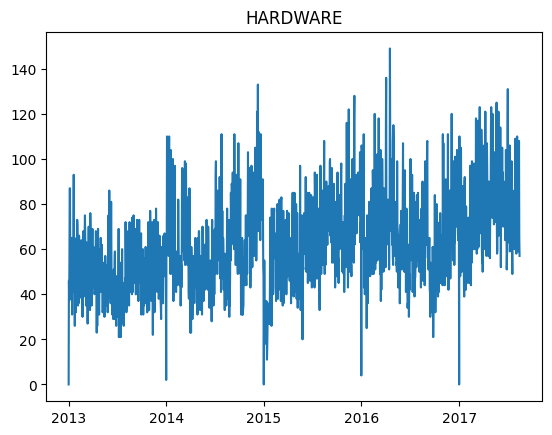

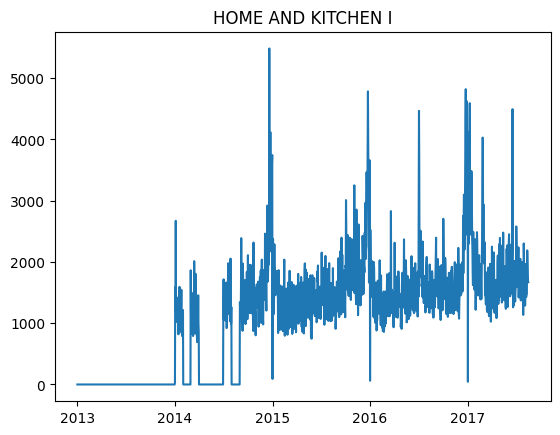

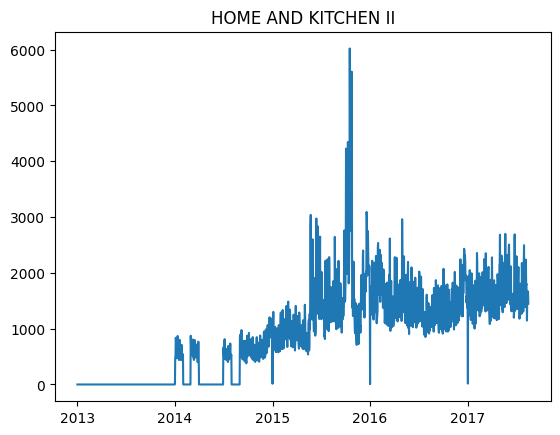

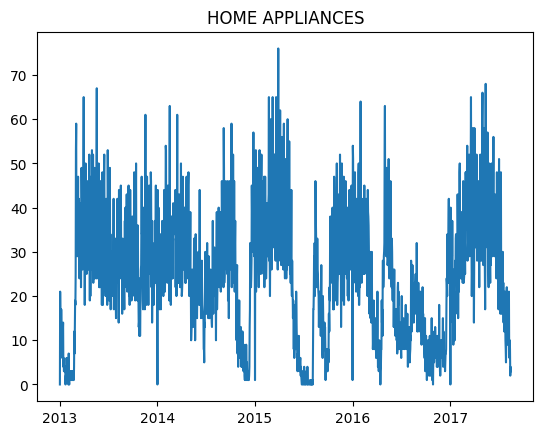

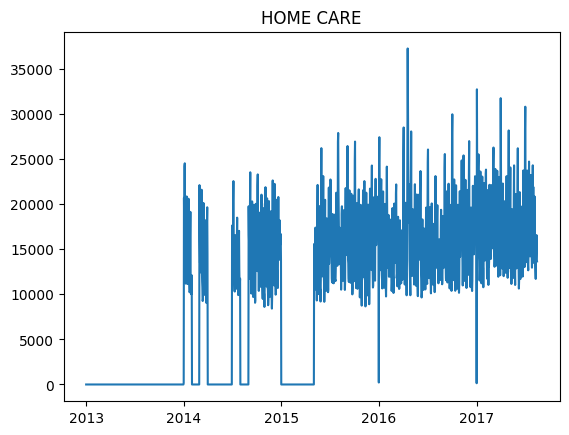

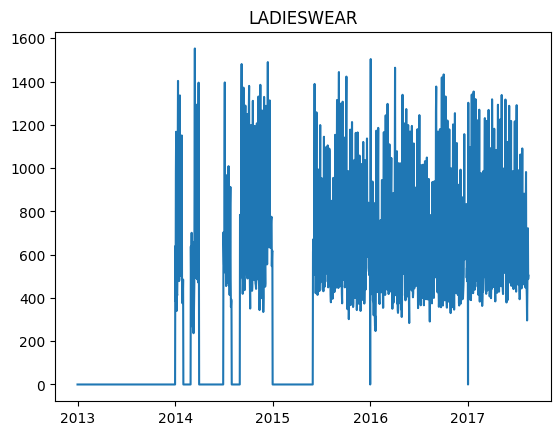

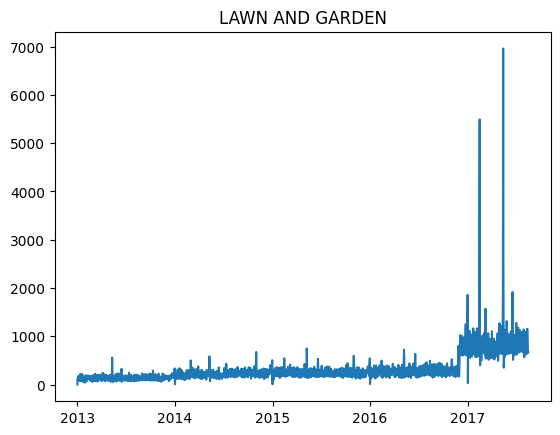

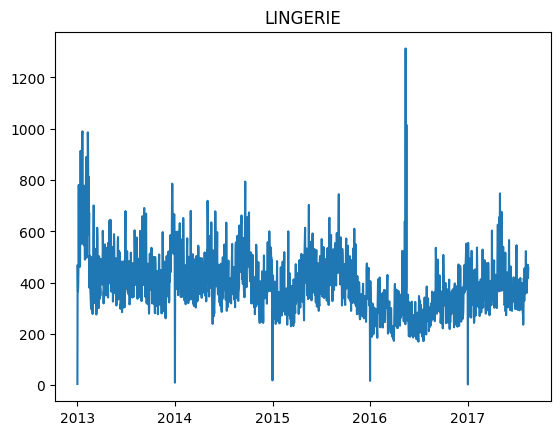

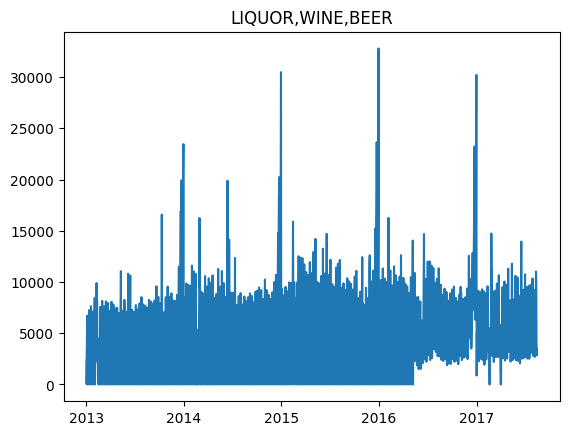

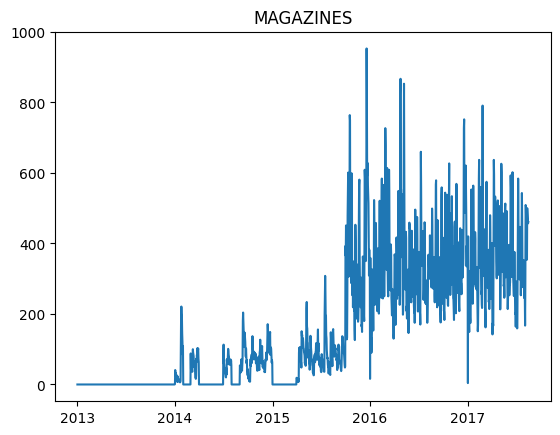

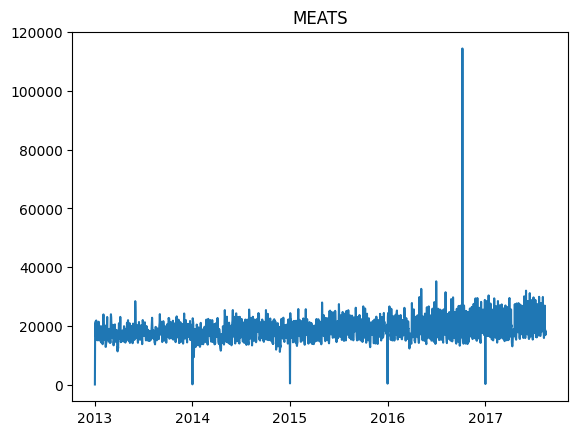

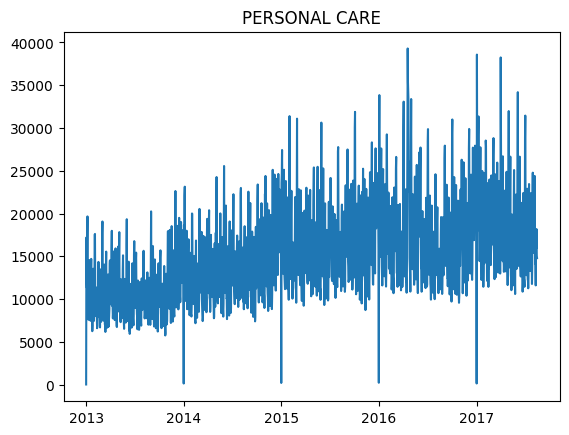

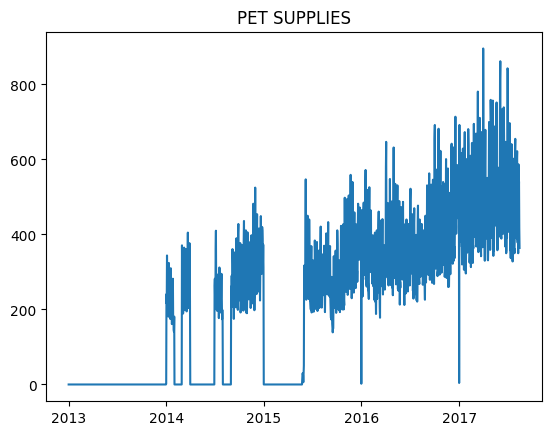

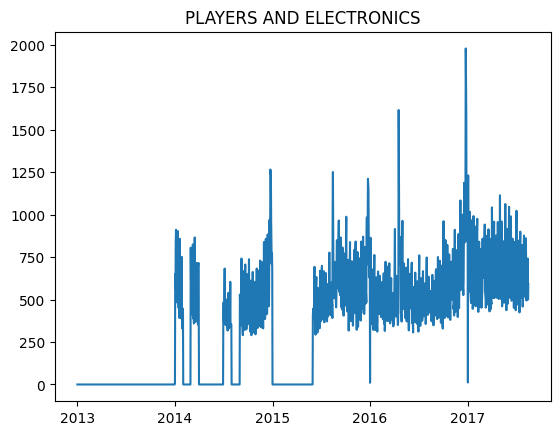

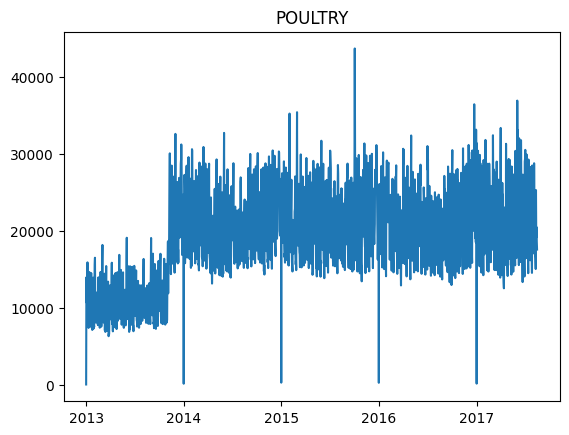

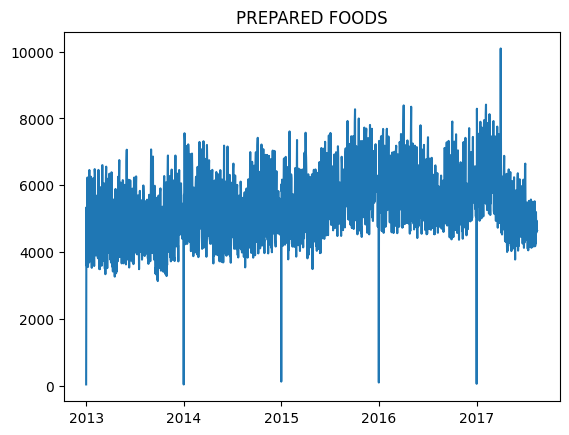

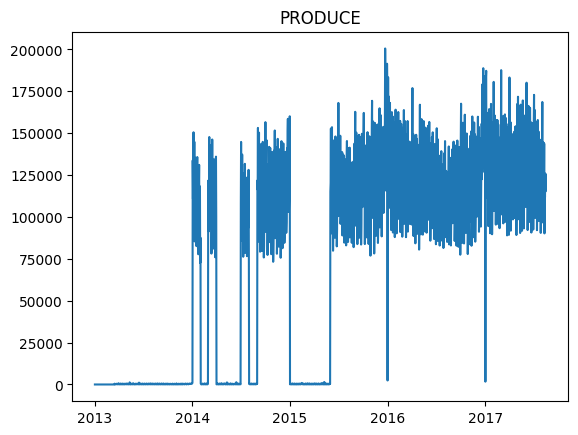

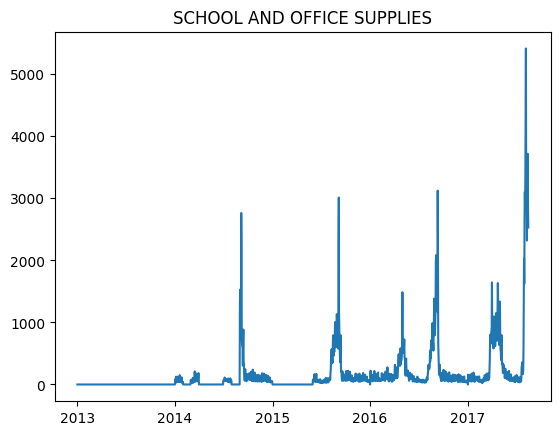

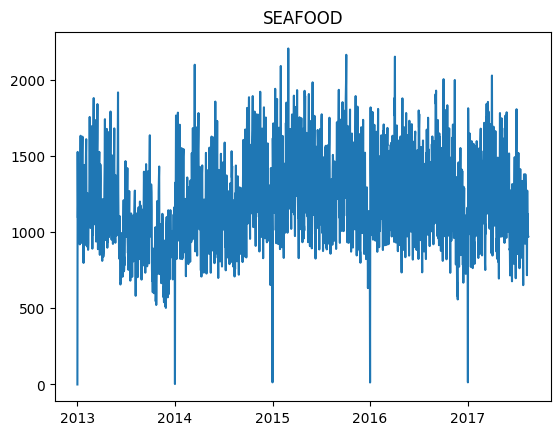

In [35]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [36]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [37]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

## Category Grouping

In [39]:
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
avg_daily_sales

family
BOOKS                             8.82
BABY CARE                        11.83
HOME APPLIANCES                  23.21
HARDWARE                         70.21
BEAUTY                          273.44
SCHOOL AND OFFICE SUPPLIES      315.06
MAGAZINES                       328.69
LINGERIE                        343.78
PET SUPPLIES                    381.50
AUTOMOTIVE                      383.20
LAWN AND GARDEN                 491.47
PLAYERS AND ELECTRONICS         576.36
LADIESWEAR                      626.31
CELEBRATION                     770.87
SEAFOOD                        1241.14
GROCERY II                     1246.87
HOME AND KITCHEN II            1560.60
HOME AND KITCHEN I             1707.09
LIQUOR,WINE,BEER               5157.08
PREPARED FOODS                 5643.84
FROZEN FOODS                   9828.31
EGGS                          10069.28
HOME CARE                     15734.36
DELI                          16222.12
PERSONAL CARE                 17091.29
MEATS             

In [40]:
# break it down by thirds for low, mid, high
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0), [33, 66])

In [41]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = list(avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<=mid)].index)
high_vol_columns = (avg_daily_sales[avg_daily_sales>mid].index)
high_vol_columns

Index(['HOME CARE', 'DELI', 'PERSONAL CARE', 'MEATS', 'POULTRY',
       'BREAD/BAKERY', 'DAIRY', 'CLEANING', 'PRODUCE', 'BEVERAGES',
       'GROCERY I'],
      dtype='object', name='family')

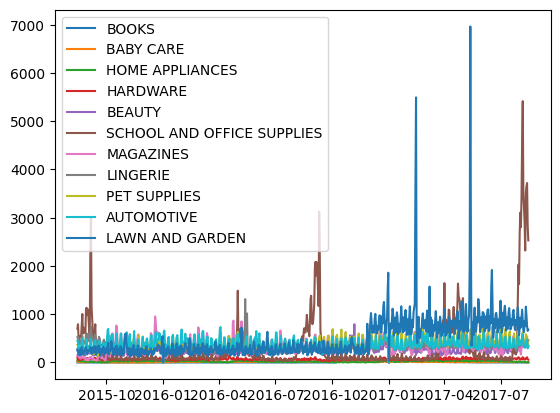

In [42]:
# Plot low volume columns
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best')
plt.show()

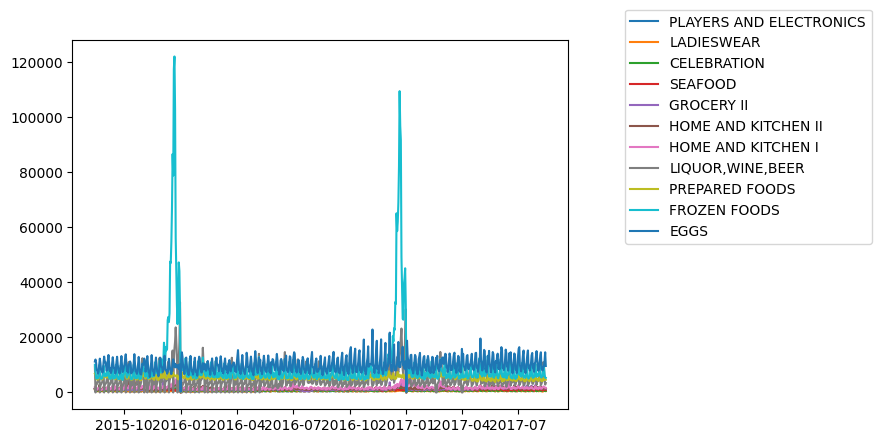

In [43]:
# Plot mid-volume columns
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.show()

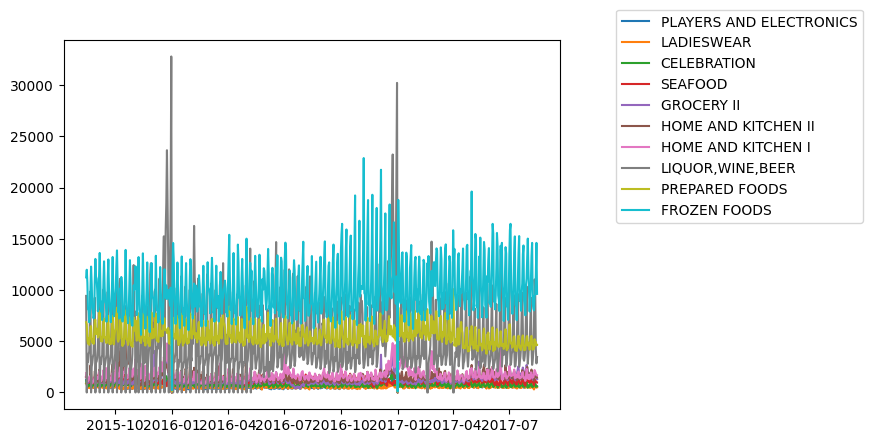

In [44]:
# Plot mid-volume columns
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.show()

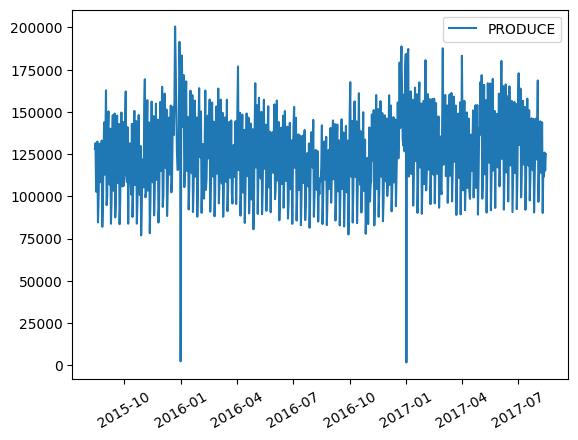

In [45]:
plt.plot(total_sales_df[high_vol_columns]["PRODUCE"])
plt.legend(["PRODUCE"], loc='best')
plt.xticks(rotation=30)
plt.show()

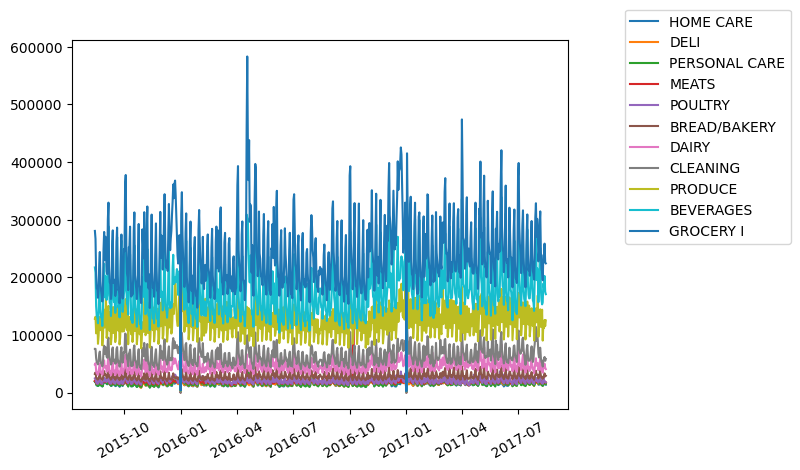

In [46]:
# Plot high-volume columns
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

# Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE"

In [47]:
feature = "PRODUCE"
prediction_days = 30

In [48]:
df = total_sales_df[[feature]].reset_index()
df

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58
...,...,...
725,2017-08-11,118738.14
726,2017-08-12,111788.35
727,2017-08-13,125923.80
728,2017-08-14,115257.60


In [49]:
# Adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC() # this is a dict
ecuador_holidays = holidays.country_holidays("EC")

for date_, name in sorted(holidays.EC(years=[2013, 2014, 2015, 2016, 2017, 2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2013-01-01,EC-Holidays,-2,1
1,2013-02-11,EC-Holidays,-2,1
2,2013-02-12,EC-Holidays,-2,1
3,2013-03-29,EC-Holidays,-2,1
4,2013-05-01,EC-Holidays,-2,1


https://pypi.org/project/holidays/

In [51]:
# avoid shadowing the name `date` (use pandas Timestamp instead)
forecast_start_dt = pd.to_datetime("2017-07-01")  # dataset ends 2017-08-15
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2017-07-01


m = Prophet(growth='linear', changepoint_range = changepoint_range, yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False, seasonality_mode='multiplicative', holidays=holiday)
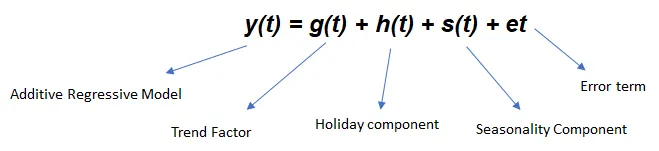

## PROPHET MODEL

In [52]:
df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date)]
train_set

family,ds,y
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58
...,...,...
679,2017-06-26,113866.38
680,2017-06-27,118274.74
681,2017-06-28,154674.94
682,2017-06-29,92482.67


In [53]:
m = Prophet()

In [54]:
m.fit(train_set)

18:17:17 - cmdstanpy - INFO - Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

In [56]:
#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

**variable considerations for prophet model**: growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily/seasonality mode, holidays

In [57]:
predicted_df.head(10)

,ds,yhat
684,2017-07-01,144551.49
685,2017-07-02,155275.69
686,2017-07-03,122322.52
687,2017-07-04,127581.75
688,2017-07-05,160193.54
689,2017-07-06,102606.61
690,2017-07-07,115957.74
691,2017-07-08,144801.88
692,2017-07-09,155526.08
693,2017-07-10,122572.90


In [58]:
df_copy = df.copy()
df_copy.columns  = ['ds', 'ytrue']
df_copy

,ds,ytrue
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58
...,...,...
725,2017-08-11,118738.14
726,2017-08-12,111788.35
727,2017-08-13,125923.80
728,2017-08-14,115257.60


In [59]:
predicted_df = predicted_df.merge(df_copy)
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144551.49,155487.63
1,2017-07-02,155275.69,172890.14
2,2017-07-03,122322.52,130389.20
3,2017-07-04,127581.75,131534.55
4,2017-07-05,160193.54,163804.33
5,2017-07-06,102606.61,99395.60
6,2017-07-07,115957.74,114346.57
7,2017-07-08,144801.88,139294.77
8,2017-07-09,155526.08,156633.92
9,2017-07-10,122572.90,118856.99


- Calculate the Mean Percentage Error of the Predicted Sales against the Actual Sales

In [60]:
mape(predicted_df['ytrue'], predicted_df['yhat']) # 6%

0.0623220813716719

In [61]:
RMSLE(predicted_df['ytrue'], predicted_df['yhat']) # 6% error, 94% accuracy

0.06880940897287337

## Cross Validation with Prophet

- Cross-validation involves selecting cut-off points in the history, and for each of them fitting the model using data only up to that cutoff point.
- We can then compare the forecasted values with the actual values

In [62]:
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon='30 days')
# initial - Initial data the model is fitted with. The first 365 days
# period - The period which the cutt-off is incremented with for every fit
# horizon - The period predicted for each cut-off, if a cut-off ends on '2016-05-05', the predicted days will be 30 days later

  0%|          | 0/10 [00:00<?, ?it/s]

18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:40 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  5.08it/s]18:17:41 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  5.19it/s]18:17:41 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  5.31it/s]18:17:41 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:01,  5.48it/s]18:17:41 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  5.39it/s]18:17:41 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:01<00:00,  5.36it/s]18:17:42 - cmdstanpy - INFO - Chain [1] start 

**performance_metrics** groups results by forecast horizon
- 3 days means 3 days ahead for all cut-offs, and finds the errors in that.
- Since the horizon is up to 30 days, it goes up to a horizon of 30 days

In [63]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-09-04,137036.95,120739.93,153890.71,144954.39,2016-09-03
1,2016-09-05,103687.07,87167.81,119965.93,110104.68,2016-09-03
2,2016-09-06,107780.07,91179.91,124330.38,115898.16,2016-09-03
3,2016-09-07,140060.64,123595.97,157442.21,142809.15,2016-09-03
4,2016-09-08,84270.20,67639.40,101270.82,85680.68,2016-09-03
...,...,...,...,...,...,...
294,2017-06-26,123269.21,102924.95,142927.84,113866.38,2017-05-31
295,2017-06-27,128445.45,109940.26,149466.27,118274.74,2017-05-31
296,2017-06-28,160988.33,141545.64,181000.26,154674.94,2017-05-31
297,2017-06-29,103723.97,84778.15,123437.43,92482.67,2017-05-31


In [64]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,409759452.40,20242.52,13048.47,0.09,0.07,0.10,0.83
1,4 days,268339806.19,16381.08,11099.49,0.08,0.06,0.08,0.80
2,5 days,140946345.45,11872.08,8898.08,0.07,0.06,0.07,0.87
3,6 days,125646213.50,11209.20,9213.11,0.07,0.07,0.07,0.87
4,7 days,95432290.20,9768.95,8406.52,0.07,0.07,0.07,0.93
5,8 days,75869971.76,8710.34,7690.15,0.06,0.07,0.06,0.97
6,9 days,61456368.34,7839.41,6612.25,0.06,0.05,0.05,1.00
7,10 days,49474591.42,7033.82,5433.14,0.05,0.04,0.05,1.00
8,11 days,78803269.22,8877.12,6728.53,0.05,0.04,0.05,0.97
9,12 days,83074123.07,9114.50,6711.98,0.05,0.05,0.05,0.93


df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.



In [65]:
df_cv['mape'] = abs((df_cv['y'] - df_cv['yhat']) / df_cv['y']) * 100
df_cv['overestimate']  = df_cv['yhat'] > df_cv['y']
df_cv.sort_values('mape', ascending=False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
118,2017-01-01,142618.41,127439.78,158519.69,1682.84,2016-12-02,8374.84,True
174,2017-02-26,160484.38,140757.39,180155.38,104141.39,2017-01-31,54.10,True
110,2016-12-23,98378.97,83144.35,114665.77,176327.97,2016-12-02,44.21,False
116,2016-12-30,98423.79,83579.98,114332.89,175022.19,2016-12-02,43.76,False
109,2016-12-22,87908.68,71769.20,103788.14,140444.94,2016-12-02,37.41,False
119,2017-01-02,117234.47,98567.69,136214.15,184113.03,2017-01-01,36.32,False
120,2017-01-03,121496.41,103187.51,139959.46,183306.23,2017-01-01,33.72,False
111,2016-12-24,127783.40,112217.60,143392.92,188809.16,2016-12-02,32.32,False
117,2016-12-31,127828.22,111180.48,143160.48,184154.67,2016-12-02,30.59,False
115,2016-12-29,87953.49,72899.95,103365.74,126652.84,2016-12-02,30.56,False


- We can conclude that mostly at the beginning of every year and some days in december, we get anomalies in sales, either sales spike too high or drop too low.

## Hyperparameter Tuning

In [66]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

In [67]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', initial='365 days', period='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses



18:20:36 - cmdstanpy - INFO - Chain [1] start processing


18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
18:20:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
18:20:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
18:20:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization t

In [68]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.20
2                      0.00                     1.00 18561.87
3                      0.00                    10.00 18653.46
4                      0.01                     0.01 18217.36
5                      0.01                     0.10 17783.71
6                      0.01                     1.00 17769.72
7                      0.01                    10.00 17708.01
8                      0.10                     0.01 18075.77
9                      0.10                     0.10 17730.74
10                     0.10                     1.00 17712.70
11                     0.10                    10.00 17700.07
12                     0.50                     0.01 18060.01
13                     0.50                     0.10 17756.79
14                     0.50                     1.00 17754.60
15      

In [69]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [70]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.10,10.00,17700.07
7,0.01,10.00,17708.01
10,0.10,1.00,17712.70
9,0.10,0.10,17730.74
14,0.50,1.00,17754.60
13,0.50,0.10,17756.79
6,0.01,1.00,17769.72
15,0.50,10.00,17782.35
5,0.01,0.10,17783.71
12,0.50,0.01,18060.01


In [72]:
future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat']) 

0.04546967470799538